In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_measurement = session.query(Measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21a45b5b9e8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
first_station = session.query(Station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21a45b6c710>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

Latest Date = ('2017-08-23',)


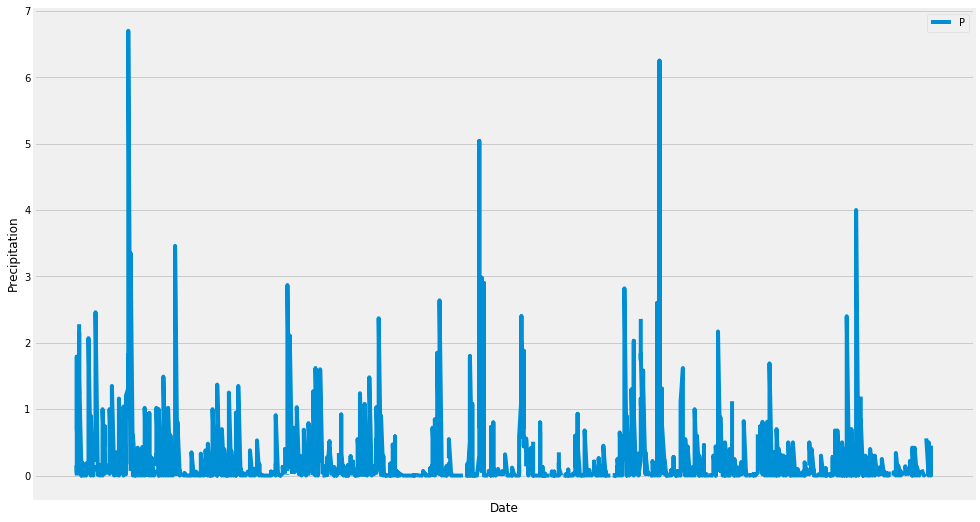

<Figure size 432x288 with 0 Axes>

In [188]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date,Measurement.prcp]
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Latest Date = {latest_date}')
# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(*sel).\
    filter(Measurement.date >= "2016-08-23").\
    order_by(Measurement.date.asc()).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12, columns=['Date', 'Precipitation'])
plt.figure(figsize=(15,9))
plt.plot(df['Date'],df['Precipitation'])
plt.xticks([])
plt.legend('Precipitation')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()
plt.tight_layout()


In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [34]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [66]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for station in session.query(Measurement.station,\
                             func.count(Measurement.station).label('Count')).group_by(Measurement.station).\
                             order_by(func.count(Measurement.station).desc()).all():
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [74]:
most_active_station = session.query(Measurement.station,\
                             func.count(Measurement.station).label('Count')).group_by(Measurement.station).\
                             order_by(func.count(Measurement.station).desc()).first()[0]
most_active_station

'USC00519281'

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


[(54.0, 85.0, 71.66378066378067)]

In [89]:
highest_temp = session.query(Measurement.tobs).\
                           filter(Measurement.station == most_active_station).\
                           order_by(Measurement.tobs.desc()).first()[0]
lowest_temp = session.query(Measurement.tobs).\
                           filter(Measurement.station == most_active_station).\
                           order_by(Measurement.tobs.asc()).first()[0]
avg_temp = session.query(func.avg(Measurement.tobs)).\
                           filter(Measurement.station == most_active_station).all()[0][0]
result = (lowest_temp,highest_temp,avg_temp)
print(result)

(54.0, 85.0, 71.66378066378067)


2017-08-18


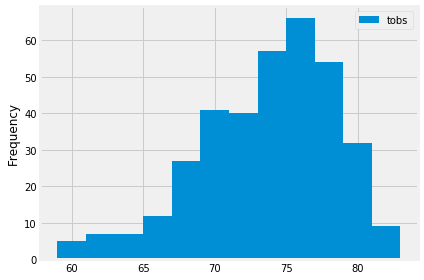

In [186]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_act_stat_early_date = session.query(Measurement.date).\
                                   filter(Measurement.station == most_active_station).\
                                   order_by(Measurement.date.desc()).first()[0]
print(most_act_stat_early_date)

high_ob_sta_12_mons = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
                              filter(Measurement.date >= '2016-08-18').all()
df = pd.DataFrame(high_ob_sta_12_mons, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

In [103]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [114]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_year_temp = calc_temps('2017-02-28', '2017-03-10')[0]
last_year_temp

(62.0, 70.53623188405797, 78.0)

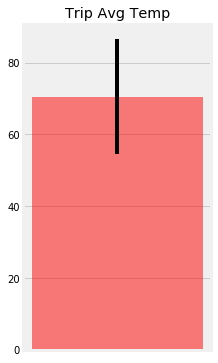

In [183]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,6))
yerror = last_year_temp[2]-last_year_temp[0]
plt.bar(0,last_year_temp[1],yerr=yerror,color='r',alpha=0.5,align='center')
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [184]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date = '2017-02-28'
trip_end_date = '2017-03-05'
sel=[Measurement.station,Station.name,\
     Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
tot_rain_per_station = session.query(*sel).\
                       group_by(Measurement.station).\
                       join(Station,Measurement.station==Station.station).\
                       filter(Measurement.date >= trip_start_date).\
                       filter(Measurement.date <= trip_end_date).\
                       order_by(func.sum(Measurement.prcp).desc()).all()

for record in tot_rain_per_station:
    print(record)

('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.720000000000001)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.07)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.7399999999999998)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.32)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.1600000000000001)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


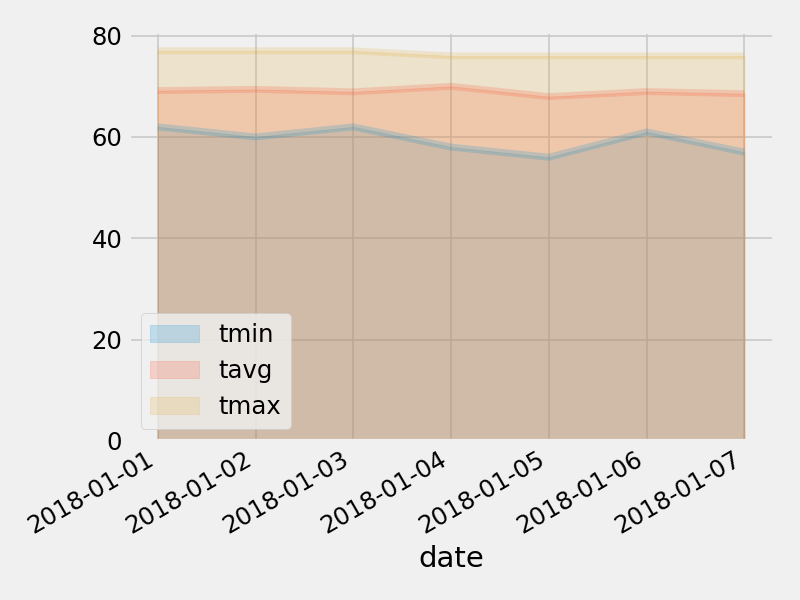

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
